In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
# Top 50 games
import requests
app_ids = {}
for page in range(1, 5):

  url = f'https://steamcharts.com/top/p.{page}'
  headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
  result = requests.get(url, headers=headers)
  soup = BeautifulSoup(result.content.decode(), 'html.parser')

  table_body = soup.select_one('#top-games tbody')

  if table_body:
      rows = table_body.find_all('tr')

      for row in rows:
          link = row.find('a')
          if link:
              href = link['href']
              app_id = href.split('/')[-1]
              name = link.text.strip()

              app_ids[app_id] = name
          else:
              print("Link not found in the row.")
  else:
      print("Table body not found.")

In [3]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
# Preprocess text (username and link placeholders)
def preprocess(text, max_length=500):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    preprocessed_text = " ".join(new_text)
    preprocessed_text = preprocessed_text[:max_length]  # Truncate to max_length
    return preprocessed_text

model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

model =  TextClassificationPipeline(model=model, tokenizer=tokenizer)

print(model('woah'))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/403 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

[{'label': 'non-toxic', 'score': 0.9974936246871948}]


In [6]:
import urllib
game_toxicity = {}
for app_id in app_ids:
  try:
    print(f'Game: {app_ids[app_id]}')
    cursor = '*'
    batch = 0

    for batch in range(2):
      print(f'Batch: {batch}')
      page = requests.get(f'https://store.steampowered.com/appreviews/{app_id}?json=1&cursor={cursor}&filter=recent&num_per_page=100').json()
      reviews = page['reviews']
      toxicity_scores = []
      for review in reviews:
          review_text = preprocess(review['review'])
          output = model(review_text)[0]
          if output['label'] == 'non-toxic':
            toxicity_scores.append(1 - output['score'])
          else:
            toxicity_scores.append(output['score'])

      if 'cursor' in page:
          cursor = urllib.parse.quote(page['cursor'])
      else:
        break

    if len(toxicity_scores) > 0:
      game_toxicity[app_ids[app_id]] = np.mean(toxicity_scores)
    else:
      game_toxicity[app_ids[app_id]] = -1
  except Exception as e:
    print(e)


Batch: 1
Game: Cyberpunk 2077
Batch: 0
Batch: 1
Game: Garry's Mod
Batch: 0
Batch: 1
Game: Sea of Thieves
Batch: 0
Batch: 1
Game: Albion Online
Batch: 0
Batch: 1
Game: Project Zomboid
Batch: 0
Batch: 1
Game: Lethal Company
Batch: 0
Batch: 1
Game: Age of Empires II: Definitive Edition
Batch: 0
Batch: 1
Game: VRChat
Batch: 0
Batch: 1
Game: SCUM
Batch: 0
Batch: 1
Game: FINAL FANTASY XIV Online
Batch: 0
Batch: 1
Game: Squad
Batch: 0
Batch: 1
Game: Mount & Blade II: Bannerlord
Batch: 0
Batch: 1
Game: Fallout: New Vegas
Batch: 0
Batch: 1
Game: Hunt: Showdown
Batch: 0
Batch: 1
Game: Summoners War
Batch: 0
Batch: 1
Game: MONSTER HUNTER RISE
Batch: 0
Batch: 1
Game: Yu-Gi-Oh!  Master Duel
Batch: 0
Batch: 1
Game: The Binding of Isaac: Rebirth
Batch: 0
Batch: 1
Game: Rocket League
Batch: 0
Batch: 1
Game: The Elder Scrolls V: Skyrim Special Edition
Batch: 0
Batch: 1
Game: Myth of Empires
Batch: 0
Batch: 1
Game: Forza Horizon 5
Batch: 0
Batch: 1
Game: MIR4
Batch: 0
Batch: 1
Game: Street Fighter™ 6
Ba

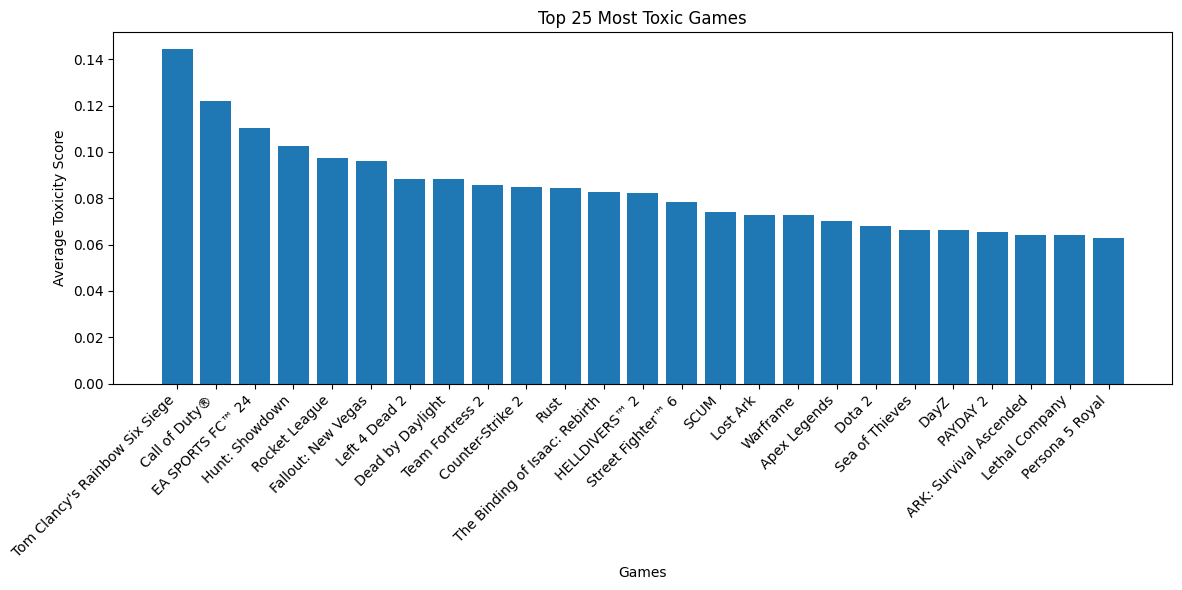

In [7]:
import matplotlib.pyplot as plt

# Plot the most toxic games
num_games_to_plot = 25
sorted_toxicity = sorted(game_toxicity.items(), key=lambda x: x[1], reverse=True)
most_toxic_games = sorted_toxicity[:num_games_to_plot]

games = [game[0] for game in most_toxic_games]
toxicity_scores = [game[1] for game in most_toxic_games]

plt.figure(figsize=(12, 6))
plt.bar(range(len(games)), toxicity_scores)
plt.xlabel('Games')
plt.ylabel('Average Toxicity Score')
plt.title(f'Top {num_games_to_plot} Most Toxic Games')
plt.xticks(range(len(games)), games, rotation=45, ha='right')
plt.tight_layout()
plt.show()